<a href="https://colab.research.google.com/github/ayarii/learner-engagement/blob/main/ResNet%2BDA_(validation%2Btraitement).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
import pathlib
import os
import zipfile
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras import layers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.model_selection import train_test_split



In [2]:

#Import dataset
data_dir = tf.keras.utils.get_file(
    "dataset.zip",
    "https://github.com/ayarii/learner-engagement/blob/main/Student-engagement-dataset.zip?raw=true",
    extract=False)
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')
data_dir = pathlib.Path('/content/datasets/Student-engagement-dataset')
print(data_dir)
print(os.path.abspath(data_dir))



40069772/40069772 [==============================] - 0s 0us/step
/content/datasets/Student-engagement-dataset
/content/datasets/Student-engagement-dataset


In [3]:
import shutil

# Chemin vers le dossier contenant vos dossiers d'ensemble de données
data_dir = '/content/datasets/Student-engagement-dataset'

# Chemin vers le dossier où vous souhaitez placer les ensembles de traitement et de validation
output_dir = '/content/datasets'

# Liste des noms de dossiers dans votre ensemble de données
folder_names = os.listdir(data_dir)

# Création des dossiers de traitement et de validation s'ils n'existent pas déjà
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Répartition des données en ensembles de traitement et de validation
for folder_name in folder_names:
    folder_path = os.path.join(data_dir, folder_name)
    images = os.listdir(folder_path)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Création des sous-dossiers dans les ensembles de traitement et de validation
    train_folder_path = os.path.join(train_dir, folder_name)
    val_folder_path = os.path.join(val_dir, folder_name)
    os.makedirs(train_folder_path, exist_ok=True)
    os.makedirs(val_folder_path, exist_ok=True)

    # Déplacement des images dans les sous-dossiers correspondants
    for image in train_images:
        shutil.copy(os.path.join(folder_path, image), os.path.join(train_folder_path, image))
    for image in val_images:
        shutil.copy(os.path.join(folder_path, image), os.path.join(val_folder_path, image))

print("Données divisées en ensembles de traitement et de validation avec succès.")



Données divisées en ensembles de traitement et de validation avec succès.


In [4]:
# Chemin vers les dossiers d'entraînement et de validation
train_dir = '/content/datasets/train/'
val_dir = '/content/datasets/validation/'

# Fonction pour compter le nombre total d'images dans un dossier
def count_images_in_directory(directory):
    total_images = 0
    # Parcours de chaque sous-dossier dans le répertoire
    for sub_directory in os.listdir(directory):
        sub_directory_path = os.path.join(directory, sub_directory)
        # Comptage des fichiers dans le sous-dossier
        if os.path.isdir(sub_directory_path):
            num_images = len([filename for filename in os.listdir(sub_directory_path)
                              if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg')])
            total_images += num_images
    return total_images

# Comptage du nombre total d'images dans chaque dossier
total_train_images = count_images_in_directory(train_dir)
total_val_images = count_images_in_directory(val_dir)

# Affichage du nombre total d'images dans chaque dossier
print("Nombre total d'images dans le dossier d'entraînement :", total_train_images)
print("Nombre total d'images dans le dossier de validation :", total_val_images)


Nombre total d'images dans le dossier d'entraînement : 1694
Nombre total d'images dans le dossier de validation : 426


In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Chemin vers le dossier contenant vos dossiers d'ensemble de données
data_dir = '/content/datasets/Student-engagement-dataset'

# Chemin vers le dossier où vous souhaitez placer les ensembles de traitement et de validation
output_dir = '/content/datasets'

# Liste des noms de dossiers dans votre ensemble de données
folder_names = os.listdir(data_dir)

# Création des dossiers de traitement et de validation s'ils n'existent pas déjà
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Répartition des données en ensembles de traitement et de validation
for folder_name in folder_names:
    folder_path = os.path.join(data_dir, folder_name)
    images = os.listdir(folder_path)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Création des sous-dossiers dans les ensembles de traitement et de validation
    train_folder_path = os.path.join(train_dir, folder_name)
    val_folder_path = os.path.join(val_dir, folder_name)
    os.makedirs(train_folder_path, exist_ok=True)
    os.makedirs(val_folder_path, exist_ok=True)

    # Déplacement des images dans les sous-dossiers correspondants
    for image in train_images:
        shutil.copy(os.path.join(folder_path, image), os.path.join(train_folder_path, image))
    for image in val_images:
        shutil.copy(os.path.join(folder_path, image), os.path.join(val_folder_path, image))

print("Données divisées en ensembles de traitement et de validation avec succès.")

# Création des générateurs de données pour l'entraînement et la validation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # VGG16 prend des images de taille 224x224
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# Chargement du modèle VGG16 pré-entraîné
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Création du modèle complet en ajoutant des couches supplémentaires au dessus du modèle VGG16
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.summary()

# Callbacks TensorBoard et EarlyStopping
log_dir = "logs/"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compilation du modèle
model.compile(optimizer=Adam(lr=1e-5), loss="categorical_crossentropy", metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[tensorboard_callback, early_stopping])


Données divisées en ensembles de traitement et de validation avec succès.
Found 1694 images belonging to 6 classes.
Found 426 images belonging to 6 classes.
58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                

Epoch 1/100
53/53 [==============================] - 85s 1s/step - loss: 1.7644 - accuracy: 0.3642 - val_loss: 0.5801 - val_accuracy: 0.7723
Epoch 2/100
53/53 [==============================] - 33s 618ms/step - loss: 0.2230 - accuracy: 0.9073 - val_loss: 0.1494 - val_accuracy: 0.9343
Epoch 3/100
53/53 [==============================] - 33s 623ms/step - loss: 0.1493 - accuracy: 0.9374 - val_loss: 0.1220 - val_accuracy: 0.9413
Epoch 4/100
53/53 [==============================] - 32s 612ms/step - loss: 0.1014 - accuracy: 0.9551 - val_loss: 0.1082 - val_accuracy: 0.9484
Epoch 5/100
53/53 [==============================] - 33s 619ms/step - loss: 0.1065 - accuracy: 0.9516 - val_loss: 0.1165 - val_accuracy: 0.9437
Epoch 6/100
53/53 [==============================] - 33s 620ms/step - loss: 0.1038 - accuracy: 0.9540 - val_loss: 0.1210 - val_accuracy: 0.9366
Epoch 7/100
53/53 [==============================] - 33s 622ms/step - loss: 0.0966 - accuracy: 0.9557 - val_loss: 0.1202 - val_accuracy: 0.

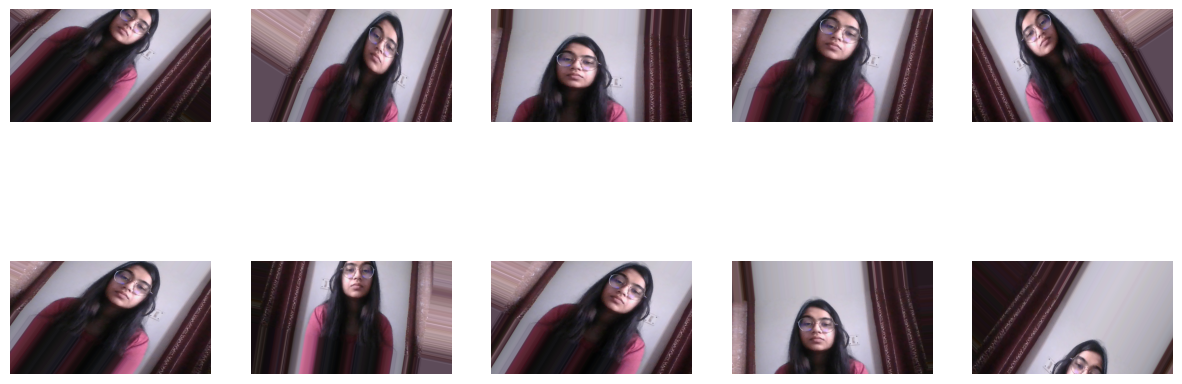

In [20]:
# Création d'un générateur de données pour l'augmentation des images
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
# Sélection d'une image à augmenter
example_image_path = os.path.join(train_dir, folder_names[0], os.listdir(os.path.join(train_dir, folder_names[0]))[0])

# Charger l'image
img = load_img(example_image_path)
x = img_to_array(img)
x = x.reshape((1,) + x.shape)  # Transforme en un tableau de forme (1, img_height, img_width, img_channels)

# Génération et affichage de 10 images augmentées
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, batch in enumerate(datagen.flow(x, batch_size=1)):
    axs[i // 5, i % 5].imshow(array_to_img(batch[0]))
    axs[i // 5, i % 5].axis('off')
    if i == 9:  # Change 9 to the desired number of images minus 1
        break

plt.show()

In [6]:
# Evaluate the model
loss, accuracy = model.evaluate(val_generator, verbose=0)
print(f'vall loss: {loss:.4f}')
print(f'vall accuracy: {accuracy:.4f}')

vall loss: 0.0669
vall accuracy: 0.9695


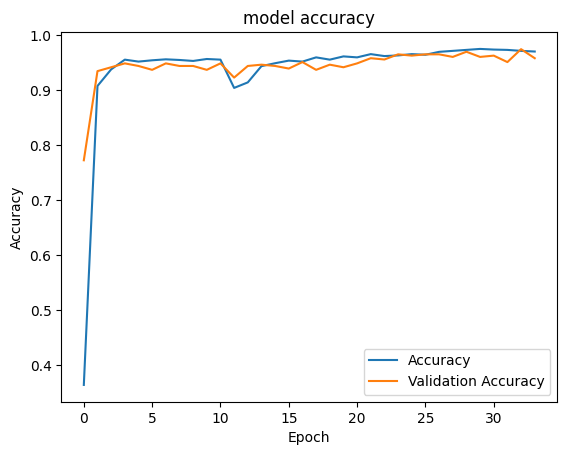

In [7]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

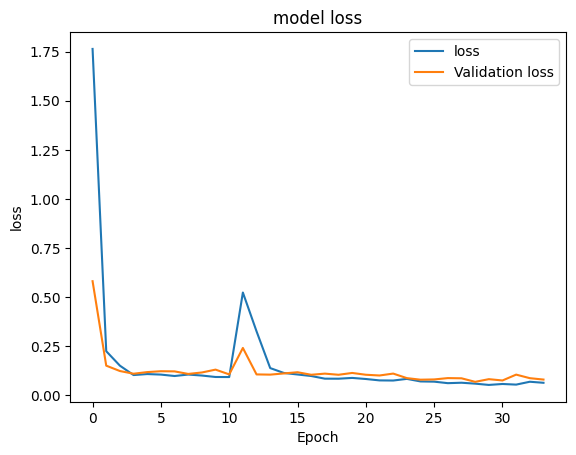

In [8]:
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation loss"])
plt.show()

In [9]:
from sklearn.metrics import classification_report

# Utilisez le modèle pour prédire les classes sur les données de validation
y_pred = model.predict(val_generator)
y_true = val_generator.classes

# Convertissez les probabilités prédites en classes prédites (classe avec la probabilité la plus élevée)
y_pred_classes = y_pred.argmax(axis=-1)

# Calcul des métriques de classification
report = classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices, output_dict=True)

# Affichage des métriques pour chaque classe
for class_name, metrics in report.items():
    print(f'Classe : {class_name}')
    print(f'   Précision : {metrics["precision"]}')
    print(f'   Rappel : {metrics["recall"]}')
    print(f'   Score F1 : {metrics["f1-score"]}')
    print(f'   Support : {metrics["support"]}\n')


14/14 [==============================] - 2s 131ms/step
Classe : Looking Away
   Précision : 0.21176470588235294
   Rappel : 0.21176470588235294
   Score F1 : 0.21176470588235294
   Support : 85

Classe : bored
   Précision : 0.16901408450704225
   Rappel : 0.16666666666666666
   Score F1 : 0.16783216783216784
   Support : 72

Classe : confused
   Précision : 0.1891891891891892
   Rappel : 0.1891891891891892
   Score F1 : 0.18918918918918917
   Support : 74

Classe : drowsy
   Précision : 0.1111111111111111
   Rappel : 0.11320754716981132
   Score F1 : 0.11214953271028037
   Support : 53

Classe : engaged
   Précision : 0.12857142857142856
   Rappel : 0.12857142857142856
   Score F1 : 0.12857142857142856
   Support : 70

Classe : frustrated
   Précision : 0.1388888888888889
   Rappel : 0.1388888888888889
   Score F1 : 0.1388888888888889
   Support : 72

Classe : accuracy


TypeError: 'float' object is not subscriptable

In [ ]:
# la matrice de confusion
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Créer un heatmap de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.title('Matrice de Confusion')
plt.show()
